# Introducción

Rusty Bargain es un servicio de venta de coches de segunda mano que está desarrollando una app para atraer a nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial, especificaciones técnicas, versiones de equipamiento y precios. 

## Objetivo

Crear un modelo que determine el valor de mercado. A Rusty Bargain le interesa:

- La calidad de la predicción.
- La velocidad de la predicción.
- El tiempo requerido para el entrenamiento.

### Tabla de contenido

1. Introducción
2. Preprocesamiento: Se trabaja con los datos y recuperación del dataframe proporcionado.
3. Entrenamiento de modelos de regresión: Implementación de los modelos de regresión lineal para la predicción de precios.
4. Conclusiones


# Preprocesamiento

Comenzaremos conociendo la información que nos proporciona `Rusty Bargain` verificando que esta contenga datos de valor y de no ser así estos serán analizados con la intención de recuperar y convertirlos en datos con valor para el objetivo.

In [62]:
# Importando librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [8]:
# Instalando librerías adicionales
!apt-get install python3-pip

zsh:1: command not found: apt-get


In [9]:
# Instalando librerías adicionales
pip install category-encoders

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Extrayendo "df"
df = pd.read_csv('datasets/car_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [11]:
# Visualizando contenido de la información
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


De manera inmediata podemos observar que hay inconcistencias (por buenas prácticas) en los nombres de las columnas por lo que deberán ser ajustados, por otro lado podemos observar que tenemos valores ausentes en las columnas:

- `VehicleType`
- `Gearbox`
- `Model`
- `FuelType`
- `NotRepaired`

Mientras que la columna objetivo (`Price`) esta completa por lo que profundizaremos en estas columnas para averiguar si los datos pueden ser recuperados en la medida de lo posible. Por último verificamos que también el tipo de dato no corresponde para algunas de estas columnas y tal es el caso para:

- `DateCrawled`
- `RegistrationMonth` (que para fines del proyecto debemos evaluar la conveniencia de ajustar el tipo de dato)
- `NotRepaired`
- `DateCreated`
- `LastSeen`

Comenzaremos trabajando con los nombres de las columnas y el tipo de dato.

In [12]:
# Renombrando columnas en "df"
data = {'DateCrawled':'date_crawled','Price':'price','VehicleType':'vehicle_type',
        'RegistrationYear':'registration_year','Gearbox':'gearbox','Power':'power',
        'Model':'model','Mileage':'mileage','RegistrationMonth':'registration_month',
        'FuelType':'fuel_type','Brand':'brand','NotRepaired':'repaired','DateCreated':'date_created',
        'NumberOfPictures':'number_pictures','PostalCode':'postal_code','LastSeen':'last_seen'}

df.rename(columns=data,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_pictures     354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [13]:
#  Ajustando tipo de datos en "df" comenzando por el tipo de dato "dateTime"
datetimelist = ['date_crawled','date_created','last_seen']
for i in datetimelist:
    df[i] = pd.to_datetime(df[i])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_pictures     354369 no

Como podemos observar, aquellas columnas que continen información de fechas ya se han cambiado al tipo de dato correcto sin embargo en este cambio, no hemos aun realizado el de la columna `repaired` al tipo `bool`, esto es porque esta columna tiene ausencia de datos por lo que trabajaremos con la ausencia de datos en `df` y posteriormente procederemos con el cambio de este tipo de dato.

## Trabajando con datos ausentes

Comenzaremos trabajando con los valores ausentes para la columna `vehicleType`. Para poder determinar este valor, es importante que sepamos cuales son las columnas que más se relacionan con esta y estas son:
- `registrationYear`: año de registro de matrícula del vehículo.
- `model`: modelo del vehiculo.
- `brand`: marca del vehículo.

In [15]:
# Creando la función "vehicleType_nan"
df_new = df.dropna().copy()

def vehicleType_nan(data):
    vehicleType = data['vehicle_type']
    registrationYear = data['registration_year']
    model = data['model']
    
    if pd.isna(vehicleType):
        result = df_new[(df_new['registration_year'] == registrationYear) &
                        (df_new['model'] == model)]['vehicle_type'].value_counts(ascending=False).index
        if len(result) > 0:
            return result[0]
        else:
            return vehicleType
    else:
        return vehicleType
    
df['vehicle_type'] = df.apply(vehicleType_nan,axis=1)
df.info()      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        334036 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_pictures     354369 no

Como podemos observar, pudimos recuperar algunos registros pues antes teníamos un total de `37,490` despues de este proceso contamos únicamente con `20,753` resultando en la recuperación de `16,737` registros. Continuaremos trabajando con las columnas que tiene registros nulos bajo la mísma dinámica con la columna `gearbox` que al ser el típo de caja de cambios, podemos asumir que depende de las mísmas colúmnas que la columna anterior.

In [16]:
# Creando la función "gearbox_nan"
df_new = df.dropna().copy()

def gearbox_nan(data):
    gearbox = data['gearbox']
    registrationYear = data['registration_year']
    model = data['model']
    
    if pd.isna(gearbox):
        result = df_new[(df_new['registration_year'] == registrationYear) &
                        (df_new['model'] == model)]['gearbox'].value_counts(ascending=False).index
        if len(result) > 0:
            return result[0]
        else:
            return gearbox
    else:
        return gearbox
    
df['gearbox'] = df.apply(gearbox_nan,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        334036 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             348351 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_pictures     354369 no

Para el caso de la columna `gearbox` de los `19,833` registros faltantes, pudimos recuperar `13,671` registros. Continuaremos con la columna `model` haciendo uso de las mismas columnas que anteriormente nos permitierón recuperar los datos.

In [19]:
# Creando la función "model_nan"
df_new = df.dropna().copy()

def model_nan(data):
    model = data['model']
    registrationYear = data['registration_year']
    brand = data['brand']
    vehicleType = data['vehicle_type']
    
    if pd.isna(model):
        result = df_new[(df_new['registration_year'] == registrationYear) &
                        (df_new['vehicle_type'] == vehicleType) &
                        (df_new['brand'] == brand)]['model'].value_counts(ascending=False).index
        if len(result) > 0:
            return result[0]
        else:
            return model
    else:
        return model
    
df['model'] = df.apply(model_nan,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        334036 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             348351 non-null  object        
 5   power               354369 non-null  int64         
 6   model               345027 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_pictures     354369 no

Para el caso de esta columna pudimos recuperar `9,499` de `19,705` registros faltantes. Para el caso de la columna `fuelType` implementaremos la misma dinámica anteriormente utilizada, sabemos que de igual forma esta compuesta en mayor medida por las columnas ya utilizadas. Pero antes analizaremos la columna un poco más a detalle, esto debido a que en las tablas presentadas de `df` anteriores, podemos observar que uno de los combustibles es `petrol` y otro `gasoline` que en ingles significan lo mismo por lo que debemos analizar dichas variantes para homologar posteriormente.

In [21]:
# Analizando la columna "fuelType"
df['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

De acuerdo con lo presentado, podemos observar que hay redundancia con los combustibles anteriormente presentados por lo que procederemos a homologar para posteriormente recuperar los registros nulos.

In [22]:
# Homologración de los combustibles en "fuelType"
df.loc[df['fuel_type'] == 'petrol','fuel_type'] = 'gasoline'
df['fuel_type'].value_counts()

gasoline    315072
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Como podemos observar, la columna ha sido homologada a través de la función `loc` por lo que procederemos con la recuperación de registros.

In [23]:
# Creando la función "fuelType_nan"
df_new = df.dropna().copy()

def fuelType_nan(data):
    fuelType = data['fuel_type']
    model = data['model']
    registrationYear = data['registration_year']
    vehicleType = data['vehicle_type']
    
    if pd.isna(fuelType):
        result = df_new[(df_new['registration_year'] == registrationYear) &
                        (df_new['model'] == model) &
                        (df_new['vehicle_type'] == vehicleType)]['fuel_type'].value_counts(ascending=False).index
        if len(result) > 0:
            return result[0]
        else:
            return fuelType
    else:
        return fuelType
    
df['fuel_type'] = df.apply(fuelType_nan,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        334036 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             348351 non-null  object        
 5   power               354369 non-null  int64         
 6   model               345027 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           344261 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_pictures     354369 no

Para esta columna pasamos de tener `32,905` registros faltantes a `14,969` dando un total de `17,936` registros recuperados del total. Por último tenemos la columna `repaired` la cuál nos indica si vehículo ha sido reparado alguna vez; de nueva cuenta analizaremos un poco a profundidad esta columna para visualizar que es lo que esta sucediendo en ella.

In [24]:
# Analizando "repaired"
df['repaired'].value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

De acuerdo a la información desplegada podemos observar que hay una tendencia considerable por la respuesta `no` en cuanto a la columna `repaired` sin embargo tenemos un total de `283,215` registros de los `354,369`, es decir, `71,154`, lo que significa que aproximadamente el `20%` del total de registros contenidos en `df` tienen ausencia de datos en esta columna.

Por otro lado y retomando nuevamente el balance de las categorías el `70%` corresponde a la categoría de `no reparación` mientras que el `10%` corresponde a la categoría `si hubó reparación`, debido a esa diferencia podemos optar por tres opciones:

- Asumir que los registros faltantes significan que corresponde a la categoría `no reparación`.
- Crear una nueva categoría con una etiqueta como `desconocido` o `sin datos`.
- Aplicar la misma dinámica anteriormente realizada a las distintas columnas.

Comenzaremos aplicando la tercera opción anteriormente mencionada esperando que estas cifras disminuyan lo más posible recuperando información del mismo `df`.

In [25]:
# Creando la función "repaired_nan"
df_new = df.dropna().copy()

def repaired_nan(data):
    repaired = data['repaired']
    model = data['model']
    registrationYear = data['registration_year']
    
    if pd.isna(repaired):
        result = df_new[(df_new['registration_year'] == registrationYear) &
                        (df_new['model'] == model)]['repaired'].value_counts(ascending=False).index
        if len(result) > 0:
            return result[0]
        else:
            return repaired
    else:
        return repaired
    
df['repaired'] = df.apply(repaired_nan,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        334036 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             348351 non-null  object        
 5   power               354369 non-null  int64         
 6   model               345027 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           344261 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            343235 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_pictures     354369 no

In [26]:
# Almacenando nuevo archivo
df.to_csv('datasets/car_data_new.csv',index=False)
df = pd.read_csv('datasets/car_data_new.csv')
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,number_pictures,postal_code,last_seen
0,2016-03-24 11:52:00,480,sedan,1993,manual,0,golf,150000,0,gasoline,volkswagen,no,2016-03-24,0,70435,2016-07-04 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,a5,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-05-04 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-06-04 10:17:00


Pudimos recuperar de los `71,154` pudimos recuperar `57,655` registros. Para el resto de valores ausentes verificaremos si hay alguna otra forma de recuperar los registros o si es conveniente eliminarnos.

In [27]:
# Verificando registros faltantes con valores nulos
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          20333
registration_year         0
gearbox                6018
power                     0
model                  9342
mileage                   0
registration_month        0
fuel_type             10108
brand                     0
repaired              11134
date_created              0
number_pictures           0
postal_code               0
last_seen                 0
dtype: int64

De acuerdo con la lista, tenemos un total de 5 columnas en las que aun tenemos registros nulos y son:

- `vehicle_type` con `20,333`, es decir, aproximadamente el `5.7%` del total de registros.
- `gearbox` con `6,018`, es decir, aproximadamente el `1.6%` del total de registros.
- `model` con `9,342`, es decir, aproximadamente el `2.6%` del total de registros.
- `fuel_type` con `10,108`, es decir, aproximadamente el `2.8%` del total de registros.
- `repaired` con `11,134`, es decir, aproximadamente el `3.1%` del total de registros.

Aun no sabemos si esta falta de registros se traslapa entre ellos por lo que vamos a encontrar la cantidad de registros completos en comparación con el total.

In [28]:
# Encontrando los registros completos
df_new = df.dropna()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330166 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        330166 non-null  object
 1   price               330166 non-null  int64 
 2   vehicle_type        330166 non-null  object
 3   registration_year   330166 non-null  int64 
 4   gearbox             330166 non-null  object
 5   power               330166 non-null  int64 
 6   model               330166 non-null  object
 7   mileage             330166 non-null  int64 
 8   registration_month  330166 non-null  int64 
 9   fuel_type           330166 non-null  object
 10  brand               330166 non-null  object
 11  repaired            330166 non-null  object
 12  date_created        330166 non-null  object
 13  number_pictures     330166 non-null  int64 
 14  postal_code         330166 non-null  int64 
 15  last_seen           330166 non-null  object
dtypes:

Aproximadamente hay una diferencia de `6.8%` entre el total de registros y el total de registros una vez se eliminarón aquellos que tienen datos faltantes. Profundizaremos un poco más sobre los registros nulos columna a columna para ver si existe alguna relación o patrón.

In [30]:
# Valores nulos en "vehicleType"
df[df['vehicle_type'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,number_pictures,postal_code,last_seen
22,2016-03-23 14:52:00,2900,NaN,2018,manual,90,meriva,150000,5,gasoline,opel,no,2016-03-23,0,49716,2016-03-31 01:16:00
26,2016-10-03 19:38:00,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-10-03,0,31139,2016-03-16 09:16:00
37,2016-03-28 17:50:00,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:00
57,2016-10-03 20:53:00,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-10-03,0,33397,2016-03-25 10:17:00
65,2016-03-28 17:41:00,10900,NaN,2017,manual,101,astra,50000,3,NaN,opel,no,2016-03-28,0,63607,2016-06-04 23:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354289,2016-05-03 14:55:00,5000,NaN,2017,manual,120,other,150000,7,NaN,citroen,yes,2016-05-03,0,15518,2016-05-04 11:48:00
354338,2016-03-31 19:52:00,180,NaN,1995,NaN,0,NaN,125000,3,gasoline,opel,NaN,2016-03-31,0,41470,2016-06-04 14:18:00
354351,2016-11-03 23:40:00,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-11-03,0,87700,2016-12-03 14:16:00
354361,2016-09-03 13:37:00,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-09-03,0,51371,2016-03-13 01:44:00


In [31]:
# Valores nulos en "gearbox"
df[df['gearbox'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,number_pictures,postal_code,last_seen
15,2016-11-03 21:39:00,450,small,1910,NaN,0,ka,5000,0,gasoline,ford,NaN,2016-11-03,0,24148,2016-03-19 08:46:00
37,2016-03-28 17:50:00,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:00
115,2016-03-20 18:53:00,0,small,1999,NaN,0,polo,5000,0,gasoline,volkswagen,no,2016-03-20,0,37520,2016-07-04 02:45:00
151,2016-03-27 20:47:00,6799,small,2009,NaN,60,polo,20000,5,gasoline,volkswagen,no,2016-03-27,0,89077,2016-03-27 20:47:00
161,2016-03-28 10:50:00,1495,wagon,2001,NaN,64,passat,150000,9,gasoline,volkswagen,no,2016-03-28,0,99086,2016-04-04 11:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354083,2016-03-30 07:54:00,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-30,0,6686,2016-06-04 23:46:00
354162,2016-07-03 19:51:00,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-07-03,0,26789,2016-03-04 11:46:00
354253,2016-03-25 09:37:00,1250,NaN,2018,NaN,0,corsa,150000,0,gasoline,opel,NaN,2016-03-25,0,45527,2016-06-04 07:46:00
354338,2016-03-31 19:52:00,180,NaN,1995,NaN,0,NaN,125000,3,gasoline,opel,NaN,2016-03-31,0,41470,2016-06-04 14:18:00


In [32]:
# Valores nulos en "model"
df[df['model'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,number_pictures,postal_code,last_seen
59,2016-03-29 15:48:00,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-06-04 01:44:00
260,2016-04-04 09:49:00,450,NaN,2016,manual,0,NaN,150000,3,gasoline,mitsubishi,no,2016-04-04,0,59302,2016-06-04 11:17:00
306,2016-03-21 14:38:00,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21,0,6493,2016-03-24 02:47:00
412,2016-03-26 21:49:00,13950,other,2011,manual,140,NaN,60000,11,gasoline,alfa_romeo,no,2016-03-26,0,86830,2016-06-04 14:15:00
431,2016-03-20 20:45:00,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20,0,90562,2016-03-04 04:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354162,2016-07-03 19:51:00,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-07-03,0,26789,2016-03-04 11:46:00
354321,2016-03-15 13:52:00,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:00
354338,2016-03-31 19:52:00,180,NaN,1995,NaN,0,NaN,125000,3,gasoline,opel,NaN,2016-03-31,0,41470,2016-06-04 14:18:00
354351,2016-11-03 23:40:00,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-11-03,0,87700,2016-12-03 14:16:00


In [33]:
# Valores nulos en "fuelType"
df[df['fuel_type'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,number_pictures,postal_code,last_seen
26,2016-10-03 19:38:00,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-10-03,0,31139,2016-03-16 09:16:00
57,2016-10-03 20:53:00,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-10-03,0,33397,2016-03-25 10:17:00
59,2016-03-29 15:48:00,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-06-04 01:44:00
65,2016-03-28 17:41:00,10900,NaN,2017,manual,101,astra,50000,3,NaN,opel,no,2016-03-28,0,63607,2016-06-04 23:15:00
163,2016-04-04 12:57:00,1200,NaN,2018,manual,75,astra,150000,0,NaN,opel,no,2016-04-04,0,15344,2016-06-04 14:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354203,2016-03-17 00:56:00,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17,0,44866,2016-03-29 15:45:00
354289,2016-05-03 14:55:00,5000,NaN,2017,manual,120,other,150000,7,NaN,citroen,yes,2016-05-03,0,15518,2016-05-04 11:48:00
354351,2016-11-03 23:40:00,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-11-03,0,87700,2016-12-03 14:16:00
354361,2016-09-03 13:37:00,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-09-03,0,51371,2016-03-13 01:44:00


In [34]:
# Valores nulos en "repaired"
df[df['repaired'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,number_pictures,postal_code,last_seen
15,2016-11-03 21:39:00,450,small,1910,NaN,0,ka,5000,0,gasoline,ford,NaN,2016-11-03,0,24148,2016-03-19 08:46:00
59,2016-03-29 15:48:00,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-06-04 01:44:00
218,2016-03-13 18:47:00,2100,NaN,2017,manual,0,zafira,150000,12,gasoline,opel,NaN,2016-03-13,0,24782,2016-03-13 18:47:00
285,2016-03-20 10:44:00,1250,NaN,2017,NaN,0,espace,150000,8,gasoline,renault,NaN,2016-03-20,0,63073,2016-03-22 16:21:00
295,2016-07-03 14:49:00,1450,NaN,2017,NaN,0,a_klasse,150000,8,gasoline,mercedes_benz,NaN,2016-07-03,0,45886,2016-08-03 00:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354140,2016-03-29 16:47:00,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29,0,38315,2016-06-04 02:44:00
354162,2016-07-03 19:51:00,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-07-03,0,26789,2016-03-04 11:46:00
354253,2016-03-25 09:37:00,1250,NaN,2018,NaN,0,corsa,150000,0,gasoline,opel,NaN,2016-03-25,0,45527,2016-06-04 07:46:00
354338,2016-03-31 19:52:00,180,NaN,1995,NaN,0,NaN,125000,3,gasoline,opel,NaN,2016-03-31,0,41470,2016-06-04 14:18:00


De manera general no podemos observar algún tipo de relación entre las columnas con registros vacios por lo que procederemos a eliminar dichos registros vacios y hacer uso de aquellos registros que se encuentren completos.

In [35]:
# Eliminando registros con datos vacios
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330166 entries, 0 to 330165
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        330166 non-null  object
 1   price               330166 non-null  int64 
 2   vehicle_type        330166 non-null  object
 3   registration_year   330166 non-null  int64 
 4   gearbox             330166 non-null  object
 5   power               330166 non-null  int64 
 6   model               330166 non-null  object
 7   mileage             330166 non-null  int64 
 8   registration_month  330166 non-null  int64 
 9   fuel_type           330166 non-null  object
 10  brand               330166 non-null  object
 11  repaired            330166 non-null  object
 12  date_created        330166 non-null  object
 13  number_pictures     330166 non-null  int64 
 14  postal_code         330166 non-null  int64 
 15  last_seen           330166 non-null  object
dtypes:

Una vez trabajados las valores ausentes, y retomando un poco lo observado en los desplegados de los `df's` anteriores, pudimos notar que la columna `numberPictures` solo muestra valores en `0` (hasta donde se alcanza a apreciar) por lo que vamos a analizar dicha columna para determinar si esta contiene datos que aporten realmente al objetivo.

In [37]:
# Analizando "numerPictures"
df['number_pictures'].value_counts()

0    330166
Name: number_pictures, dtype: int64

Como podemos observar, esta columna únicamente nos aporta un solo dato como información lo que nos lleva a concluir que para este punto es una columna irrelevante para el objetivo por lo que procederemos a eliminarla de `df` ademas también de aquellas columnas de fechas pues para determinar el precio de los vehículos no son relevantes.

In [38]:
# Eliminando la columna "numberPictures"
df = df.drop(columns=['number_pictures','date_crawled','registration_month','date_created','last_seen','postal_code'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330166 entries, 0 to 330165
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              330166 non-null  int64 
 1   vehicle_type       330166 non-null  object
 2   registration_year  330166 non-null  int64 
 3   gearbox            330166 non-null  object
 4   power              330166 non-null  int64 
 5   model              330166 non-null  object
 6   mileage            330166 non-null  int64 
 7   fuel_type          330166 non-null  object
 8   brand              330166 non-null  object
 9   repaired           330166 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.2+ MB


Una cosa más encontrada en los desplegados de los `df's` es que hay registros que en la columna `price` (columna objetivo) tienen un valor de `0` y `1` hasta donde se puede observar, por lo que de igual forma, profundizaremos en dicha columna para entender cuál es su distribución y poder determinar como trabajar dichos casos.

In [39]:
# Observando distribución de la columna "price"
df['price'].value_counts()

0        8546
500      5185
1500     4952
1200     4215
1000     4156
         ... 
6235        1
1379        1
5377        1
3021        1
10985       1
Name: price, Length: 3663, dtype: int64

De acuerdo con el desplegado, podemos observar que hay una gran cantidad de registros que tienen la columna `price` con valor de `0`, dando un total aproximado de `2.5%` de los resgistros totales. Es una columna delicada de trabajar puesto que al ser la columna objetivo, no podemos inferir la información que esta contiene realmente aplicando procesos como los anteriormente vistos por lo que solamente prescidiremos de estos registros pues modificiarlos podría afectar por completo los modelos de predicción.

In [40]:
# Eliminando registros con valores "0" en la columna "price"
idx = df[df['price'] == 0].index
df.drop(labels=idx,inplace=True)
df.reset_index(inplace=True,drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321620 entries, 0 to 321619
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              321620 non-null  int64 
 1   vehicle_type       321620 non-null  object
 2   registration_year  321620 non-null  int64 
 3   gearbox            321620 non-null  object
 4   power              321620 non-null  int64 
 5   model              321620 non-null  object
 6   mileage            321620 non-null  int64 
 7   fuel_type          321620 non-null  object
 8   brand              321620 non-null  object
 9   repaired           321620 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.5+ MB


Por otro lado, visualizaremos la tendencia de la columna `registration_year` con la intención de encotrar algún tipo de anomalía dentro de ella.

<AxesSubplot:title={'center':'Comportamiento de "registration_year"'}, ylabel='Frequency'>

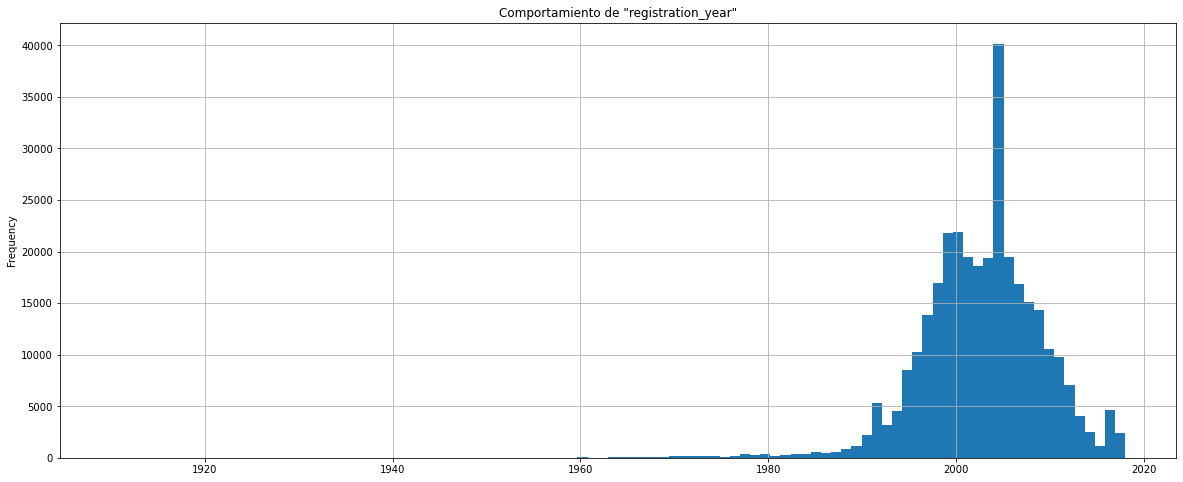

In [42]:
# Visualizando la columna "registration_year"
df['registration_year'].plot.hist(figsize=(20,8),grid=True,title='Comportamiento de "registration_year"',bins=100)

Como podemos apreciar en el gráfico, si bien no se logra identificar alguna barra de tendencia desde `1960` y hacia atras, podemos apreciar que el gráfico contempla dicha escala por lo que es importante visualizar que es lo que hay detras de este año.

In [44]:
# Filtrando registros de "1960" y hacia atras
df[df['registration_year'] < 1960].sort_values(by='registration_year', ascending=True)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,repaired
89027,1,sedan,1910,manual,10,other,5000,gasoline,mercedes_benz,no
9176,1250,sedan,1910,manual,0,other,5000,gasoline,audi,no
197995,1,convertible,1910,manual,0,other,5000,gasoline,fiat,no
106565,8750,convertible,1923,manual,11,c3,5000,gasoline,citroen,no
294118,8750,convertible,1923,manual,8,c3,5000,gasoline,citroen,no
...,...,...,...,...,...,...,...,...,...,...
274696,4500,sedan,1959,manual,50,other,5000,gasoline,mercedes_benz,yes
238381,1200,sedan,1959,manual,26,other,50000,gasoline,renault,no
245622,17200,coupe,1959,auto,230,other,150000,gasoline,ford,no
35243,18500,sedan,1959,manual,30,kaefer,70000,gasoline,volkswagen,no


In [49]:
# Filtrando registros de "1940" y hacia atras
df[df['registration_year'] < 1940].sort_values(by='registration_year', ascending=True)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,repaired
9176,1250,sedan,1910,manual,0,other,5000,gasoline,audi,no
89027,1,sedan,1910,manual,10,other,5000,gasoline,mercedes_benz,no
197995,1,convertible,1910,manual,0,other,5000,gasoline,fiat,no
294118,8750,convertible,1923,manual,8,c3,5000,gasoline,citroen,no
106565,8750,convertible,1923,manual,11,c3,5000,gasoline,citroen,no
305057,20000,coupe,1929,manual,12,other,10000,gasoline,bmw,yes
124686,11500,convertible,1929,manual,15,other,5000,gasoline,bmw,yes
208700,11500,convertible,1929,manual,15,other,5000,gasoline,bmw,yes
178317,1,other,1929,manual,0,other,70000,gasoline,mercedes_benz,yes
278103,16800,other,1930,manual,24,other,150000,gasoline,ford,no


Como podemos observar en la tabla, tenemos registros en la columna `registration_year` que se refiere al año del vehículo que estan por debajo de `1920`, es decir, son unidades con más de 100 años, estos registros tienen una peculiaridad y es que en la mayoría se tiene la marca a la pertenecen y el tipo de vehículo sin embargo no se cuenta con el modelo pues la etiqueta que aparece es `other`, lo que nos lleva a una grave aportación de ruido a la información del dataset por lo que son registros que deben ser omitidos de nuestro análisis.

Los abordaremos eliminando aquellos registros que cumplan dos condiciones, la primera es que la columna `registration_year` sea menor a `1960` que es el año en el que todavía se cuentan con registros de valor y que ademas la columna `model` tenga la etiqueta `other` asignada.

In [50]:
# Elimiando registros menores a "1960" con modelo igual a "other"
idx = df[(df['registration_year'] < 1960) & (df['model'] == 'other')].index
df.drop(labels=idx,inplace=True)
df.reset_index(inplace=True,drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321506 entries, 0 to 321505
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              321506 non-null  int64 
 1   vehicle_type       321506 non-null  object
 2   registration_year  321506 non-null  int64 
 3   gearbox            321506 non-null  object
 4   power              321506 non-null  int64 
 5   model              321506 non-null  object
 6   mileage            321506 non-null  int64 
 7   fuel_type          321506 non-null  object
 8   brand              321506 non-null  object
 9   repaired           321506 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.5+ MB


<AxesSubplot:title={'center':'Comportamiento de "registration_year"'}, ylabel='Frequency'>

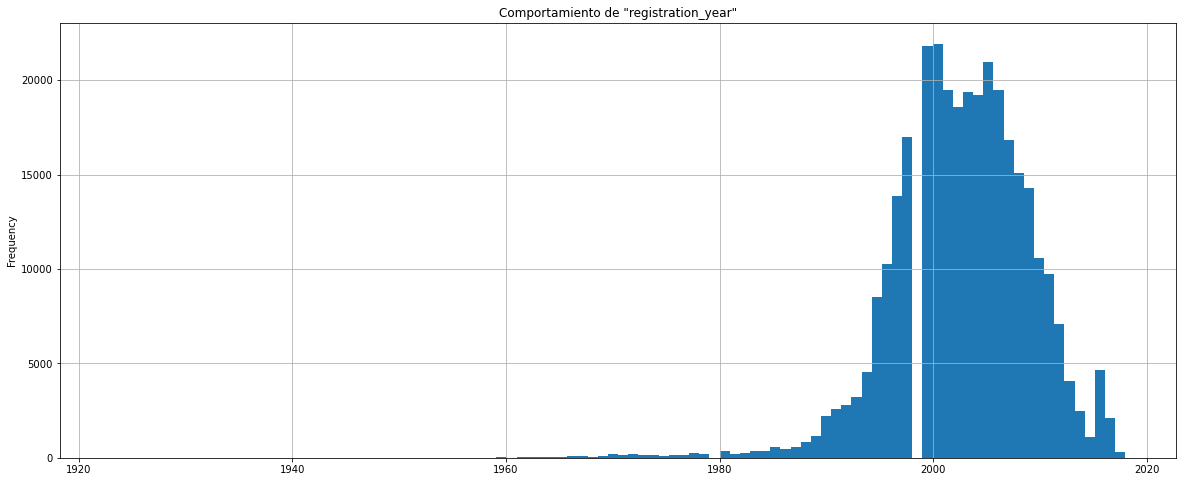

In [51]:
# Visualizando la columna "registration_year"
df['registration_year'].plot.hist(figsize=(20,8),grid=True,title='Comportamiento de "registration_year"',bins=100)

Como podemos observar en la tabla presentada ya contamos con la información de relevancia para la columna objetivo que es `price`. Continuaremos con el entrenamiento de diferentes modelos y lo que esto implica.

# Entrenamiento de modelos de regresión lineal

Comenzaremos con el modelo básico que es `regresión lineal múltiple`, para poder procesar la información primero debemos trabajar aquellas columnas categóricas, analizando cuál es el método más eficiente para las mismas pues contamos con:

- OneHotEncoder
- LabelEncoder

Para esto analizaremos la cantidad de categorías con las que cuenta cada una de las columnas categóricas para poder definir cuales serán trabajadas bajo que proceso.

In [52]:
# Analizando columnas categóricas
df['vehicle_type'].value_counts()

sedan          94163
small          82096
wagon          65997
bus            29387
convertible    19638
coupe          16063
suv            11405
other           2757
Name: vehicle_type, dtype: int64

In [53]:
# Analizando columnas categóricas
df['model'].value_counts()

golf                  28411
other                 24011
3er                   19775
polo                  12851
corsa                 11970
                      ...  
samara                    5
i3                        5
serie_3                   3
range_rover_evoque        2
rangerover                2
Name: model, Length: 249, dtype: int64

In [54]:
# Analizando columnas categóricas
df['brand'].value_counts()

volkswagen       70989
opel             35473
bmw              34567
mercedes_benz    29587
audi             27365
ford             23030
renault          15950
peugeot          10194
fiat              8629
seat              6205
skoda             5258
mazda             5094
smart             4878
citroen           4676
nissan            4529
toyota            4300
hyundai           3337
mini              3018
volvo             2993
mitsubishi        2690
honda             2482
kia               2257
suzuki            2156
alfa_romeo        2060
chevrolet         1614
chrysler          1277
dacia              860
daihatsu           700
subaru             679
porsche            672
jeep               612
land_rover         503
saab               498
jaguar             478
daewoo             473
trabant            413
rover              412
lancia             408
lada               190
Name: brand, dtype: int64

In [55]:
# Analizando columnas categóricas
df['fuel_type'].value_counts()

gasoline    315739
lpg           4856
cng            514
hybrid         201
other          130
electric        66
Name: fuel_type, dtype: int64

In [56]:
# Analizando columnas categóricas
df['gearbox'].value_counts()

manual    258432
auto       63074
Name: gearbox, dtype: int64

In [57]:
# Analizando columnas categóricas
df['repaired'].value_counts()

no     289215
yes     32291
Name: repaired, dtype: int64

Como podemos observar para el caso de las columnas `vehicleType`, `model`, `brand` y `fuelType` la cantidad de categorías es bastante amplia en comparación con `gearbox` y `repaired` que solo manejan dos cartegorías. Describiremos el funcionamiento básico de cada una de las codificaciones de categorías para definir como es que serán estas trabajadas.

- `OneHotEncoder`: Efectuará una codificación de categorías generando columnas con datos binarios, lo que quiere decir es que generará tantas columnas como categorías diferentes contenidas dentro de la columna a codificar (menos una columna para evitar redundancia). Ademas también esta codificación es aplicada a las variables independinetes.
- `LabelEncoder`: Asignará un valor numérico a cada categoría encontrada en la columna a codificar. Esta codificación debe ser aplicada a la variable dependiente.

Tomando en cuenta lo anteriormente mencionado, también es un hecho que la forma de trabajo de `OneHotEncoder` no será la codificación óptima para aquellas columnas que tienen muchas categorías contenidas, por lo que optaremos por una alternativa llamada `TargetEncoder` que lo que hace es que en comparación con la columna categórica y la columna objetivo se encuentra la cantidad promedio de veces que esta categoría resulta en dicho valor objetivo permitiendo obtener cantidades decimales que nos permitirán trabajar de forma adecuada con los modelos de regresión.

De acuerdo a lo anterior podemos identificar que haremos uso de `TargetEncoder` y `OneHotEncoder` para poder trabajar las columnas categóricas.

## Aplicando "OneHotEncoder"

In [60]:
# Aplicando la codificación de categorías
X = df.drop(columns=['price'],axis=1)
y = df['price']

encoder = OneHotEncoder()
X = encoder.fit_transform(X)
X

<321506x1054 sparse matrix of type '<class 'numpy.float64'>'
	with 2893554 stored elements in Compressed Sparse Row format>

Como podemos observar ya contamos con los valores adecuados para las distintas columnas que contenían valores categorícos, por lo que podemos crear un nuevo `df` que contenga dichos valores y poder alimentar los algoritmos de regresión lineal.

## Modelo de "Regresión lineal múltiple"

In [61]:
# Obteniendo conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=12345)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((241129, 1054), (80377, 1054), (241129,), (80377,))

In [70]:
# Entrenando modelo de regresió lineal múltiple
lr = LinearRegression()
lr.fit(X_train,y_train)
start_lr = time.time()
y_pred = lr.predict(X_test)
end_lr = time.time()
score_lr = mean_squared_error(y_test,y_pred,squared=False)
print('La evaluación del modelo bajo la métrica "RECM" es:',score_lr)
print('El tiempo de ejecución es de:',end_lr-start_lr,'s')

La evaluación del modelo bajo la métrica "RECM" es: 1995.12132301006
El tiempo de ejecución es de: 0.0012350082397460938 s


Como podemos observar, la métrica de evaluación nos coloca las espectativas algo altas pues podremos tomar este resultado como prueba de cordura al ser el algorítmo de regresión líneal más simple, el desempeño de este esta realtivamente limitado en comparación del resto; añadiendo ademas que al momento de realizar la potenciación del gradiente, la evaluación de la misma debe mejorar el `score` obtenido en este modelo.

## Modelo de regresión lineal "Árboles de decisión"

In [64]:
# Encontrando los mejores hiper parámetros
dtr = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': range(2, 4), 
              'min_samples_split': range(2, 10,2), 
              'min_samples_leaf': range(2, 10,2),
              'criterion': ['squared_error', 'friedman_mse','poisson']}
grid = GridSearchCV(dtr, parameters, cv=5, n_jobs=-1,scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score:  -3804.6910533912787
Best estimator:  DecisionTreeRegressor(max_depth=3, min_samples_leaf=2, random_state=12345)


In [65]:
# Implementado modelo de regresión lineal
dtr = DecisionTreeRegressor(criterion='squared_error',max_depth=3,min_samples_leaf=2,min_samples_split=2,random_state=12345)
dtr.fit(X_test,y_test)
start_dtr = time.time()
y_pred = dtr.predict(X_test)
end_dtr = time.time()
score_dtr = mean_squared_error(y_test,y_pred,squared=False)
print('La evaluación del modelo bajo la métrica "RECM" es:',score_dtr)
print('El tiempo de ejecución es de:',end_dtr-start_dtr,'s')


La evaluación del modelo bajo la métrica "RECM" es: 3821.9358551056002
El tiempo de ejecución es de: 0.006018161773681641 s


## Modelo de regresión lineal "Bosques aleatorios"

In [67]:
# Encontrando los mejores hiper parámetros
model_rfr = RandomForestRegressor(random_state=12345)
parameters = {'max_depth': range(2,4),
              'min_samples_split': range(2,10,2),
              'min_samples_leaf': range(2,10,2),
              'criterion': ['squared_error','friedman_mse','poisson']}
grid = GridSearchCV(model_rfr, parameters, cv=5, n_jobs=-1,scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score:  -3775.716277023633
Best estimator:  RandomForestRegressor(max_depth=3, min_samples_leaf=2, random_state=12345)


In [68]:
# Implementado modelo de regresión lineal
rfr = DecisionTreeRegressor(criterion='squared_error',max_depth=3,min_samples_leaf=2,min_samples_split=2,random_state=12345)
rfr.fit(X_test,y_test)
start_rfr = time.time()
y_pred = rfr.predict(X_test)
end_rfr = time.time()
score_rfr = mean_squared_error(y_test,y_pred,squared=False)
print('La evaluación del modelo bajo la métrica "RECM" es:',score_rfr)
print('El tiempo de ejecución es de:',end_rfr-start_rfr,'s')


La evaluación del modelo bajo la métrica "RECM" es: 3821.9358551056002
El tiempo de ejecución es de: 0.00419306755065918 s


Para la potenciación del gradiente haremos uso de `LightGBM` el cuál nos permitirá aplicar la potenciación del gradiente minimizando el `overfiting` y a través de la busqueda de gradiente de una forma más optimizada, nos puede ofrecer mejores resultados de predicción en la regresión líneal. Explicaremos brevemente lo que este algoritmo recibe como parámetros.

Este algoritmo datasets completos en el que se específica cuales son las columnas `features` y cuál(es) es(son) la(s) columna(s) `target`. Por lo que debemos crear dos `Datasets` uno para los registros de entrenamiento y otro para los registros de testeo.

Debemos crear un objeto (por limpieza de código) que recibirá los parámetros de configuración del algoritmo `LightGBM` dentro de los cuales usaremos los siguientes:

- `boosting_type`: El tipo de cálculo del gradiente a utilizar.
- `objective`: Especifica la tarea de parendizaje, es decir, si se trata de una regresión o una clasificación.
- `metric`: Métrica de evaluación a utilizar.
- `num_leaves`: Máximo de hojas del árbol para los estudiantes base.
- `learning_rate`: Tasa de aprendizaje.

## Potenciación de gradiente "LightGBM"

In [69]:
# "LightGBM" para datos numéricos
train_data = lgb.Dataset(X_train,label=y_train)
test_data = lgb.Dataset(X_test,label=y_test)

params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': 31,
          'learning_rate': 0.05}

model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])
start_gbm = time.time()
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
end_gbm = time.time()
score_gbm = mean_squared_error(y_test,y_pred,squared=False)
print('La evaluación del modelo bajo la métrica "RECM" es:',score_gbm)
print('El tiempo de ejecución es de:',end_gbm-start_gbm,'s')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1194
[LightGBM] [Info] Number of data points in the train set: 241129, number of used features: 597
[LightGBM] [Info] Start training from score 4633.680669
[1]	valid_0's rmse: 4431.37
[2]	valid_0's rmse: 4314.12
[3]	valid_0's rmse: 4205.24
[4]	valid_0's rmse: 4103.3
[5]	valid_0's rmse: 4009.21
[6]	valid_0's rmse: 3921.38
[7]	valid_0's rmse: 3840.41
[8]	valid_0's rmse: 3769.18
[9]	valid_0's rmse: 3703.61
[10]	valid_0's rmse: 3639.02
[11]	valid_0's rmse: 3581.26
[12]	valid_0's rmse: 3523.38
[13]	valid_0's rmse: 3470.06
[14]	valid_0's rmse: 3420.14
[15]	valid_0's rmse: 3373.88
[16]	valid_0's rmse: 3330.06
[17]	valid_0's rmse: 3286.91
[18]	valid_0's rmse: 3242.41
[19]	valid_0's rmse: 3206.09
[20]	valid_0's rmse: 3169.42
[21]	valid_0's r

[275]	valid_0's rmse: 1819.83
[276]	valid_0's rmse: 1819.42
[277]	valid_0's rmse: 1818.9
[278]	valid_0's rmse: 1818.5
[279]	valid_0's rmse: 1818
[280]	valid_0's rmse: 1817.44
[281]	valid_0's rmse: 1817.01
[282]	valid_0's rmse: 1816.55
[283]	valid_0's rmse: 1815.89
[284]	valid_0's rmse: 1815.49
[285]	valid_0's rmse: 1815.15
[286]	valid_0's rmse: 1814.67
[287]	valid_0's rmse: 1814.33
[288]	valid_0's rmse: 1813.77
[289]	valid_0's rmse: 1813.26
[290]	valid_0's rmse: 1812.85
[291]	valid_0's rmse: 1812.48
[292]	valid_0's rmse: 1812.09
[293]	valid_0's rmse: 1811.66
[294]	valid_0's rmse: 1811.2
[295]	valid_0's rmse: 1810.74
[296]	valid_0's rmse: 1810.16
[297]	valid_0's rmse: 1809.68
[298]	valid_0's rmse: 1809.11
[299]	valid_0's rmse: 1808.77
[300]	valid_0's rmse: 1808.46
[301]	valid_0's rmse: 1807.87
[302]	valid_0's rmse: 1807.46
[303]	valid_0's rmse: 1807.09
[304]	valid_0's rmse: 1806.71
[305]	valid_0's rmse: 1806.35
[306]	valid_0's rmse: 1805.86
[307]	valid_0's rmse: 1805.45
[308]	valid_0's 

[595]	valid_0's rmse: 1734.26
[596]	valid_0's rmse: 1734.17
[597]	valid_0's rmse: 1734.03
[598]	valid_0's rmse: 1733.71
[599]	valid_0's rmse: 1733.63
[600]	valid_0's rmse: 1733.4
[601]	valid_0's rmse: 1733.21
[602]	valid_0's rmse: 1733.05
[603]	valid_0's rmse: 1732.9
[604]	valid_0's rmse: 1732.84
[605]	valid_0's rmse: 1732.72
[606]	valid_0's rmse: 1732.63
[607]	valid_0's rmse: 1732.5
[608]	valid_0's rmse: 1732.29
[609]	valid_0's rmse: 1732.11
[610]	valid_0's rmse: 1731.93
[611]	valid_0's rmse: 1731.84
[612]	valid_0's rmse: 1731.72
[613]	valid_0's rmse: 1731.61
[614]	valid_0's rmse: 1731.31
[615]	valid_0's rmse: 1731.19
[616]	valid_0's rmse: 1731.02
[617]	valid_0's rmse: 1730.85
[618]	valid_0's rmse: 1730.73
[619]	valid_0's rmse: 1730.52
[620]	valid_0's rmse: 1730.43
[621]	valid_0's rmse: 1730.36
[622]	valid_0's rmse: 1730.23
[623]	valid_0's rmse: 1730.1
[624]	valid_0's rmse: 1729.97
[625]	valid_0's rmse: 1729.87
[626]	valid_0's rmse: 1729.8
[627]	valid_0's rmse: 1729.73
[628]	valid_0's

[884]	valid_0's rmse: 1700.14
[885]	valid_0's rmse: 1700.07
[886]	valid_0's rmse: 1700.03
[887]	valid_0's rmse: 1699.96
[888]	valid_0's rmse: 1699.9
[889]	valid_0's rmse: 1699.87
[890]	valid_0's rmse: 1699.79
[891]	valid_0's rmse: 1699.71
[892]	valid_0's rmse: 1699.61
[893]	valid_0's rmse: 1699.5
[894]	valid_0's rmse: 1699.44
[895]	valid_0's rmse: 1699.31
[896]	valid_0's rmse: 1699.24
[897]	valid_0's rmse: 1699.12
[898]	valid_0's rmse: 1699.01
[899]	valid_0's rmse: 1698.91
[900]	valid_0's rmse: 1698.83
[901]	valid_0's rmse: 1698.65
[902]	valid_0's rmse: 1698.57
[903]	valid_0's rmse: 1698.5
[904]	valid_0's rmse: 1698.43
[905]	valid_0's rmse: 1698.41
[906]	valid_0's rmse: 1698.31
[907]	valid_0's rmse: 1698.27
[908]	valid_0's rmse: 1698.18
[909]	valid_0's rmse: 1698.12
[910]	valid_0's rmse: 1698.05
[911]	valid_0's rmse: 1698.03
[912]	valid_0's rmse: 1697.89
[913]	valid_0's rmse: 1697.77
[914]	valid_0's rmse: 1697.73
[915]	valid_0's rmse: 1697.68
[916]	valid_0's rmse: 1697.59
[917]	valid_0

Con la intención de observar mejor los resultados crearemos un nuevo `df` que contenga la información acerca del tiempo de ejecución, `RECM` de testeo y de entrenamiento.

In [72]:
data_resutl = {'Modelo':['Regresión lineal múltiple','Árboles de decisión','Bosques aleatorios','LightGBM'],
               'Tiempo de ejecución (s)':[end_lr-start_lr,end_dtr-start_dtr,end_rfr-start_rfr,end_gbm-start_gbm],
               'RECM':[score_lr,score_dtr,score_rfr,score_gbm]}
result = pd.DataFrame(data=data_resutl)
result

,Modelo,Tiempo de ejecución (s),RECM
0,Regresión lineal múltiple,0.001235,1995.121323
1,Árboles de decisión,0.006018,3821.935855
2,Bosques aleatorios,0.004193,3821.935855
3,LightGBM,1.764330,1690.406049


# Conclusiones

El hacer uso de la potencialización de grandiente de forma adecuada al momento de hacer predicciones tanto de clasificación como de regresión, permite que la calidad del algoritmo pueda aumentar minimizando el sobre entrenamiento pues se encarga de evaluar dicho rendimiento a través de diversas métricas permitiendoce a través de la iteraciones, corregir los errores encontrados a lo mínimo posible. Por otro lado, es importante considerar que las librerías de potencialización de gradiente sacrifican el tiempo de predicción por predicciones más certeras por lo que es importante evaluar que tan importante es recibir respuestas con el mínimo grado de error posible a costa de un tiempo de procesamiento más extenso.